In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !rm -rf "/content/output_folder/"
!unzip "/content/drive/MyDrive/Dataset/navigationDataset.zip" -d "/content/"
base_dir = "/content/navigationDataset"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
folders=os.listdir(train_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Dataset/navigationDataset.zip
   creating: /content/navigationDataset/test/
   creating: /content/navigationDataset/test/koridor/
  inflating: /content/navigationDataset/test/koridor/koridor (104).jpg  
  inflating: /content/navigationDataset/test/koridor/koridor (121).jpg  
  inflating: /content/navigationDataset/test/koridor/koridor (123).jpg  
  inflating: /content/navigationDataset/test/koridor/koridor (126).jpg  
  inflating: /content/navigationDataset/test/koridor/koridor (128).jpg  
  inflating: /content/navigationDataset/test/koridor/koridor (139).jpg  
  inflating: /content/navigationDataset/test/koridor/koridor (140).jpg  
  inflating: /content/navigationDataset/test/koridor/koridor (163).jpg  
  inflating: /content/navigationDataset/test/koridor/koridor (171).jpg  
  inflating: /content/navigationDataset/test/korido

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras import models
from keras.utils import to_categorical, plot_model
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input, Activation
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, Callback , ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# initial parameters
epochs = 100
batch_size = 32
input_size = (224,224)

# image augmentation part
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   brightness_range=[0.2,1.0],
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=input_size,
                                                 color_mode="rgb",
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 seed=42)

val_set = train_datagen.flow_from_directory(validation_dir,
                                            target_size=input_size,
                                            color_mode="rgb",
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=True,
                                            seed=42)

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=input_size,
                                            color_mode="rgb",
                                            batch_size=1,
                                            class_mode=None,
                                            shuffle=False,
                                            seed=42)

Found 2438 images belonging to 5 classes.
Found 303 images belonging to 5 classes.
Found 309 images belonging to 5 classes.


In [4]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=val_set.n//val_set.batch_size
STEP_SIZE_TEST=test_set.n//test_set.batch_size

In [5]:
model = Sequential([
    Input(shape=(*input_size, 3)),
    Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      1

In [6]:
#Optimizer Adam
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

#Compiling the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/pasca_sarjana/computer_vision/project_koridor/model/custom_model.h5", verbose=1, save_best_only=True)

In [7]:
# fit the cnn model to the trainig set and testing it on the test set
hist = model.fit_generator(
          training_set,
          steps_per_epoch=STEP_SIZE_TRAIN,
          epochs = epochs,
          callbacks=[early_stop, checkpoint],
          validation_data=val_set,
          validation_steps=STEP_SIZE_VALID)

<ipython-input-7-0d5a46ebc986>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 2.0434 - accuracy: 0.3217
Epoch 1: val_loss improved from inf to 1.63650, saving model to /content/drive/MyDrive/pasca_sarjana/computer_vision/project_koridor/model/custom_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 [==============================] - 93s 966ms/step - loss: 2.0434 - accuracy: 0.3217 - val_loss: 1.6365 - val_accuracy: 0.2569
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 1.3591 - accuracy: 0.5200
Epoch 2: val_loss did not improve from 1.63650
76/76 [==============================] - 71s 941ms/step - loss: 1.3591 - accuracy: 0.5200 - val_loss: 2.1303 - val_accuracy: 0.2500
Epoch 3/100
76/76 [==============================] - ETA: 0s - loss: 0.9971 - accuracy: 0.6438
Epoch 3: val_loss did not improve from 1.63650
76/76 [==============================] - 69s 912ms/step - loss: 0.9971 - accuracy: 0.6438 - val_loss: 3.0858 - val_accuracy: 0.1597
Epoch 4/100
76/76 [==============================] - ETA: 0s - loss: 0.8420 - accuracy: 0.6937
Epoch 4: val_loss did not improve from 1.63650
76/76 [==============================] - 69s 910ms/step - loss: 0.8420 - accuracy: 0.6937 - val_loss: 3.9129 - val_accuracy: 0.2500
Epoch 5/100
76/76 [===========================

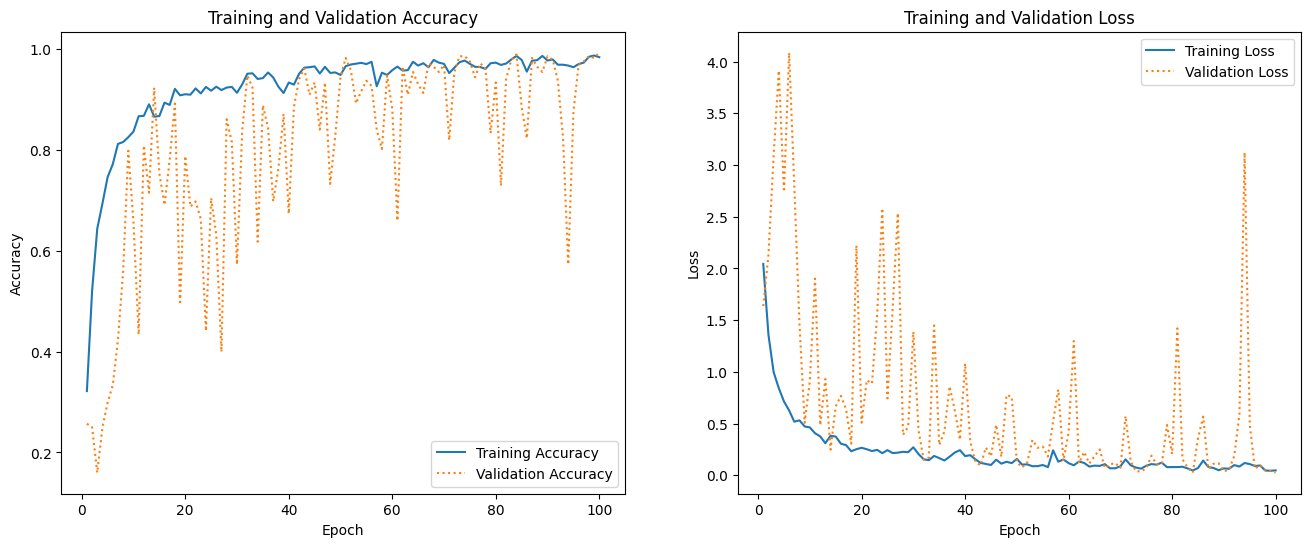

In [8]:
#Getting the accuracy
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

#Getting the losses
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, ':', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
model = models.load_model('/content/drive/MyDrive/pasca_sarjana/computer_vision/project_koridor/model/custom_model.h5')
score_val = model.evaluate_generator(val_set, steps=STEP_SIZE_VALID)
print('val loss:', score_val[0])
print('val accuracy:', score_val[1])

<ipython-input-9-7f611b1fa44e>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score_val = model.evaluate_generator(val_set, steps=STEP_SIZE_VALID)


val loss: 0.02462043985724449
val accuracy: 0.9965277910232544


In [16]:
print(test_set.class_indices)

{'koridor': 0, 'lift': 1, 'pintu_darurat': 2, 'pintu_ruangan': 3, 'tangga': 4}


 19/309 [>.............................] - ETA: 1s

<ipython-input-18-628245052cf6>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predicted = model.predict_generator(test_set, steps=STEP_SIZE_TEST, verbose=1)


309/309 [==============================] - 5s 15ms/step


Text(72.24687500000006, 0.5, 'Actual label')

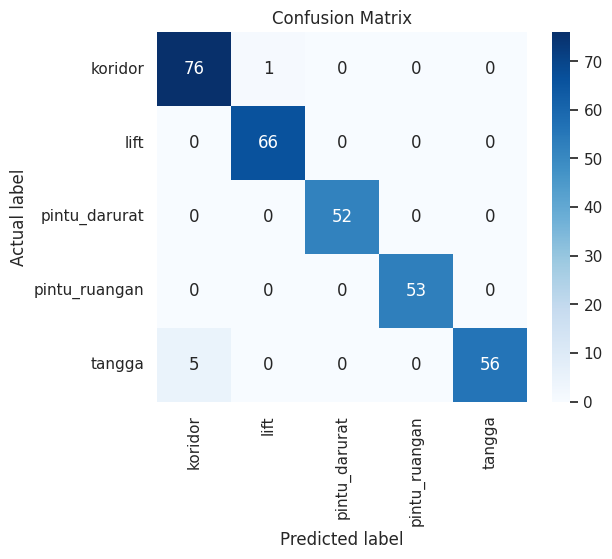

In [18]:
# Predict validation data
sns.set()
test_set.reset()
test_predicted = model.predict_generator(test_set, steps=STEP_SIZE_TEST, verbose=1)
y_pred = np.argmax(test_predicted, axis=1)
mat = confusion_matrix(test_set.classes, y_pred)
class_labels = ['koridor', 'lift', 'pintu_darurat', 'pintu_ruangan', 'tangga']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [19]:
print(classification_report(test_set.classes, y_pred, target_names=class_labels))

               precision    recall  f1-score   support

      koridor       0.94      0.99      0.96        77
         lift       0.99      1.00      0.99        66
pintu_darurat       1.00      1.00      1.00        52
pintu_ruangan       1.00      1.00      1.00        53
       tangga       1.00      0.92      0.96        61

     accuracy                           0.98       309
    macro avg       0.98      0.98      0.98       309
 weighted avg       0.98      0.98      0.98       309



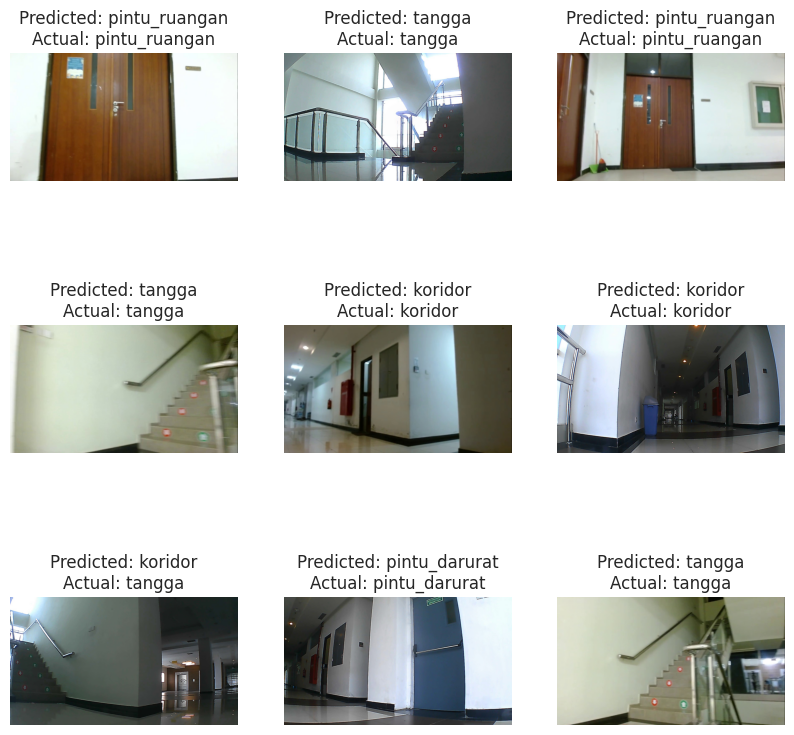

In [20]:
plt.figure(figsize=(10, 10))
indices = np.random.choice(len(test_set.classes), 9, replace=False)
for i, index in enumerate(indices):
    ax = plt.subplot(3, 3, i + 1)
    img_path = test_set.filepaths[index]
    img = plt.imread(img_path)
    plt.imshow(img.astype("uint8"))
    plt.title(f'Predicted: {class_labels[y_pred[index]]}\nActual: {class_labels[test_set.classes[index]]}')
    plt.axis("off")

In [ ]:
# def predict(path):
#     imageShow = tf.keras.preprocessing.image.load_img(path, target_size=(500,500))
#     image = tf.keras.preprocessing.image.load_img(path, target_size=input_size)
#     image_array = tf.keras.preprocessing.image.img_to_array(image)
#     image_array = tf.expand_dims(image_array, axis=0)  # Create batch axis
#     image_array /= 255
#     dictionary = {0 : 'koridor', 1 : 'lift', 2 : 'pintu', 3 : 'pintu_darurat', 4 : 'tangga'}
#     predictions = model.predict(image_array)
#     for i, label in enumerate(class_labels):
#       print(f'{label}: {predictions[0][i]}')
#     score = predictions[0]
#     predicted_class = np.argmax(score)
#     predictions = dictionary[predicted_class]
#     plt.imshow(imageShow)
#     plt.title(predictions)
#     plt.axis("off")
#     plt.show()

In [ ]:
# predict(test_dir+'/1.jpg')